In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bigmart-sales-data/Train.csv
/kaggle/input/bigmart-sales-data/Test.csv


Problem Statement:

The data scientists have collected data from BigMart, which consists of 14204 records of the products and their respective attributes. We have to predict the sales figures of products sold in 10 different stores located in various cities. 

Hypothesis:

Number of Sales are effected by
* Time of week
* Time of day
* Time of year
* Store size and location
* Item itself

In [79]:
#import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn import model_selection
import math

In [4]:
#load train and test dataset in dataframes
trainDf= pd.read_csv("/kaggle/input/bigmart-sales-data/Train.csv")
testDf= pd.read_csv("/kaggle/input/bigmart-sales-data/Test.csv")

In [5]:
#Shape of Datasets
print(trainDf.shape, testDf.shape)

(8523, 12) (5681, 11)


In [6]:
#View columns of train datsets
trainDf.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [7]:
#View columns of test datsets
testDf.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [8]:
#combine train and test data for Exploratory Data Analysis
trainDf["source"]= "train"
testDf["source"]="test"
Data= pd.concat([trainDf, testDf], ignore_index= True)

In [9]:
#View no. or rows and columns in new dataframe
Data.shape

(14204, 13)

In [10]:
#View columns of Dataset
Data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'source'],
      dtype='object')

In [11]:
#View top 5 records
Data.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [12]:
Data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [13]:
#View Missing Values
Data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [14]:
#unique values of Item_Fat_Content
Data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [15]:
#There are only two categories of Item Fat Content: Low Fat and Regular. Replacing alternative spellings 
Data["Item_Fat_Content"]= Data["Item_Fat_Content"].replace(['low fat','LF'],'Low Fat')
Data["Item_Fat_Content"]= Data["Item_Fat_Content"].replace('reg','Regular')

In [16]:
#unique values of Outlet_Identifier
Data["Outlet_Size"].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [17]:
#unique values of Outlet_Establishment_Year Outlet_Size 
Data["Outlet_Establishment_Year"].unique()

array([1999, 2009, 1998, 1987, 1985, 2002, 2007, 1997, 2004])

In [18]:
#Determine Outlet Age 
Data["Outlet_Age"]= 2023 - Data["Outlet_Establishment_Year"]

In [19]:
#unique values of Outlet_Type
Data["Outlet_Type"].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

**Dealing with Missing Vaues:**

There are 2439 missing values in Item Weight column, 4016 missing values in Outlet Size and 5681 missing values in Item Outlet Sales( we will predict them) column.

There are also some nan values in Outlet_Size column

In [20]:
#Filling missing values in Item Weight with average weight
Data["Item_Weight"]= Data["Item_Weight"].fillna(Data["Item_Weight"].mean())

In [21]:
#Filling missing values of Outlet Size with mode of outlet Size
Data["Outlet_Size"]= Data["Outlet_Size"].fillna(Data["Outlet_Size"].mode()[0])

In [22]:
Data["Outlet_Size"].value_counts()

Medium    8671
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

**Visualizing Data**

<Figure size 432x288 with 0 Axes>

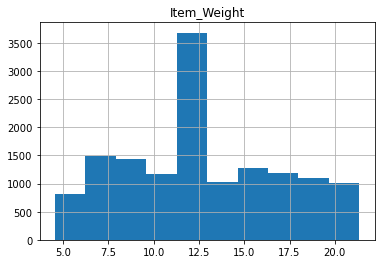

<Figure size 432x288 with 0 Axes>

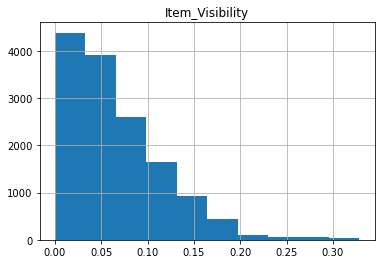

<Figure size 432x288 with 0 Axes>

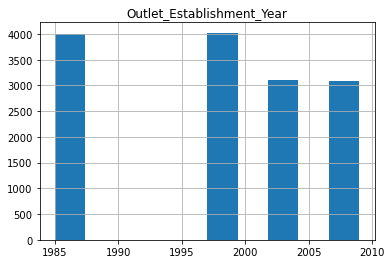

In [23]:
#Visualizing Data
dCol=['Item_Weight', 'Item_Visibility',
      'Outlet_Establishment_Year']
for col in dCol:
    plt.figure()
    Data.hist(col)

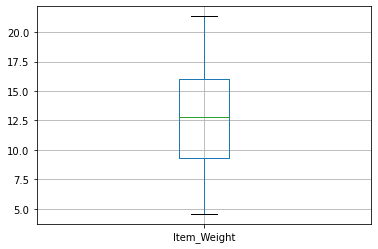

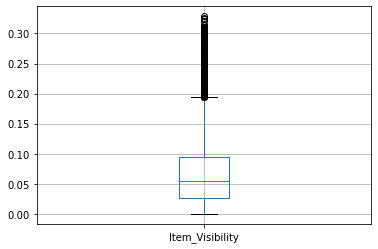

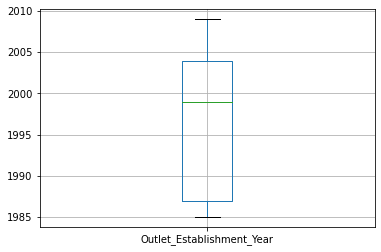

In [24]:
#Visualizing Data to identify outliers (box plot)
dCol=['Item_Weight', 'Item_Visibility',
      'Outlet_Establishment_Year']
for col in dCol:
    plt.figure()
    Data.boxplot(col)

Removing OutLiers

There are outliers in Item Visibility Coloumn, lets remove outliers.

Outliers= Q1-(1.5 * IQR)< x < Q3+ (1.5 * IQR)

Q1= 0.25

Q3= 0.75

IQR= Q3-Q1

In [25]:
#calculating values of Q1, Q3, IQR

Q1= Data["Item_Visibility"].quantile(0.25)
Q3= Data["Item_Visibility"].quantile(0.75)
IQR= Q3-Q1
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

In [26]:
#Fitering Data without Outliers and saving it
# NData= Data.query(filtered)
NData= Data.query('(@Q1 - (1.5 * @IQR) ) <= Item_Visibility <= (@Q3 + (1.5 * @IQR))')

In [27]:
#Shape of NewDataset without outliers
NData.shape

(13943, 14)

In [28]:
#Shape of Orignal Dataset without outliers
Data.shape

(14204, 14)

In [29]:
Data=NData

In [30]:
Data.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,24
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,14
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,24
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800,train,25
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,36


**Feature Engineering**

Coding all categorical variables into numerical using label encoder from sklearn preprocessing module

* Item Fat Content: Low Fat, Regular

* Outlet Size: Small, Medium, High

* Outlet Type: Supermarket Type1, Supermarket Type2, Supermarket Type3, Grocery Store



In [31]:
#intialize label encoder
le= LabelEncoder()

In [32]:
# Transform Item Fat Content, Outlet Size and Outlet Type
Data["Outlet_Size"]= le.fit_transform(Data["Outlet_Size"])
Data["Item_Fat_Content"]= le.fit_transform(Data["Item_Fat_Content"])

In [33]:
#print unique values of Outlet Type
Data["Outlet_Type"].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

In [34]:
#create dummy values for Outlet Type
dummy = pd.get_dummies(Data["Outlet_Type"])
dummy.head(5)

,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
0,0,1,0,0
1,0,0,1,0
2,0,1,0,0
3,1,0,0,0
4,0,1,0,0


In [35]:
Data.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Age
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,1,Tier 1,Supermarket Type1,3735.1380,train,24
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2009,1,Tier 3,Supermarket Type2,443.4228,train,14
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,1999,1,Tier 1,Supermarket Type1,2097.2700,train,24
3,FDX07,19.20,1,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,1,Tier 3,Grocery Store,732.3800,train,25
4,NCD19,8.93,0,0.000000,Household,53.8614,OUT013,1987,0,Tier 3,Supermarket Type1,994.7052,train,36


In [36]:
Data["Item_Type"].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [37]:
Data["Item_Identifier"].value_counts()

FDE33    10
FDM12    10
FDY47    10
FDT03    10
FDO01    10
         ..
FDA10     7
FDO33     7
FDZ60     7
NCW54     7
FDG21     7
Name: Item_Identifier, Length: 1559, dtype: int64

In [38]:
#Multiples Categories of Items are present we can combine them throuh mapping
Data["Item_Type_Category"]= Data["Item_Identifier"].apply(lambda i: i [0:2])
Data["Item_Type_Category"]= Data["Item_Type_Category"].map({"FD": "Food", "DR": "Drink", "NC":"Non-Consumable"})

In [39]:
Data["Item_Type_Category"].value_counts()

Food              9991
Non-Consumable    2652
Drink             1300
Name: Item_Type_Category, dtype: int64

In [40]:
Data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Age,Item_Type_Category
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,1,Tier 1,Supermarket Type1,3735.1380,train,24,Food
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2009,1,Tier 3,Supermarket Type2,443.4228,train,14,Drink


In [41]:
#coding categorical values of Item Type Category into numerical values by label encoder
Data["Item_Type_Category"]= le.fit_transform(Data["Item_Type_Category"])

In [42]:
Data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'source', 'Outlet_Age',
       'Item_Type_Category'],
      dtype='object')

In [43]:
#Performing one hot encoding for columns 
Data=pd.get_dummies(Data, columns=['Item_Fat_Content','Outlet_Size','Outlet_Location_Type', 'Outlet_Type','Item_Type_Category'])


In [44]:
Data.head(2)

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,source,Outlet_Age,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_Category_0,Item_Type_Category_1,Item_Type_Category_2
0,FDA15,9.30,0.016047,Dairy,249.8092,OUT049,1999,3735.1380,train,24,...,1,0,0,0,1,0,0,0,1,0
1,DRC01,5.92,0.019278,Soft Drinks,48.2692,OUT018,2009,443.4228,train,14,...,0,0,1,0,0,1,0,1,0,0


In [45]:
Data.shape

(13943, 25)

In [46]:
Data.dtypes

Item_Identifier                   object
Item_Weight                      float64
Item_Visibility                  float64
Item_Type                         object
Item_MRP                         float64
Outlet_Identifier                 object
Outlet_Establishment_Year          int64
Item_Outlet_Sales                float64
source                            object
Outlet_Age                         int64
Item_Fat_Content_0                 uint8
Item_Fat_Content_1                 uint8
Outlet_Size_0                      uint8
Outlet_Size_1                      uint8
Outlet_Size_2                      uint8
Outlet_Location_Type_Tier 1        uint8
Outlet_Location_Type_Tier 2        uint8
Outlet_Location_Type_Tier 3        uint8
Outlet_Type_Grocery Store          uint8
Outlet_Type_Supermarket Type1      uint8
Outlet_Type_Supermarket Type2      uint8
Outlet_Type_Supermarket Type3      uint8
Item_Type_Category_0               uint8
Item_Type_Category_1               uint8
Item_Type_Catego

In [47]:
#Droping columns whose data type is converted to numerical
Data.drop(["Item_Type","Outlet_Establishment_Year"],axis=1,inplace= True)

In [48]:
#Dividing dataset into training and testing dataset
Train= Data.loc[Data["source"]=="train"]
Test= Data.loc[Data["source"]=="test"]

In [50]:
Test.head(2)

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Age,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Size_0,Outlet_Size_1,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_Category_0,Item_Type_Category_1,Item_Type_Category_2
8523,FDW58,20.75,0.007565,107.8622,OUT049,24,1,0,0,1,...,1,0,0,0,1,0,0,0,1,0
8524,FDW14,8.30,0.038428,87.3198,OUT017,16,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0


In [51]:
#Export modified test and train data
Train.to_csv("Train_Modified.csv", index=False)
Test.to_csv("Test_Modified.csv", index=False)

In [52]:
train=pd.read_csv("Train_Modified.csv")
test=pd.read_csv("Test_Modified.csv")

In [53]:
train.head(2)

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Item_Outlet_Sales,Outlet_Age,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Size_0,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_Category_0,Item_Type_Category_1,Item_Type_Category_2
0,FDA15,9.30,0.016047,249.8092,OUT049,3735.1380,24,1,0,0,...,1,0,0,0,1,0,0,0,1,0
1,DRC01,5.92,0.019278,48.2692,OUT018,443.4228,14,0,1,0,...,0,0,1,0,0,1,0,1,0,0


In [83]:
#Dropping unnecessary columns in train and test datasets
x_train=train.drop(['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'], axis=1)
y_train=train["Item_Outlet_Sales"]

x_test= test.drop(['Item_Identifier','Outlet_Identifier'],axis=1)

In [85]:
#view shape of x_train and y_train
print('Shape of x_train{} '.format(x_train.shape))
print('Shape of y_train{} '.format(y_train.shape))
print('Shape of x_test{} '.format(x_test.shape))

Shape of x_train(8375, 19) 
Shape of y_train(8375,) 
Shape of x_test(5568, 19) 


**Model Building**

In [99]:
#Creating Train test split
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(x_train, y_train, test_size=0.2)

In [100]:
#Fit Linear Regression to dataset

lr= LinearRegression()

In [101]:
lr.fit(xtrain,ytrain)

LinearRegression()

In [102]:
#Finding intercept of line and coefficient
print(lr.intercept_)
print('\n {}'.format(lr.coef_))

1210.3701767197745

 [-1.19336332e+00 -4.82652198e+02  1.57758796e+01 -3.44138990e+01
 -1.00207766e+01  1.00207766e+01  5.33907990e+02 -2.91104753e+02
 -2.42803237e+02  2.23711055e+02  1.48825050e+01 -2.38593560e+02
 -1.63558075e+03 -1.64138797e+02 -3.69380921e+02  2.16910046e+03
  3.25965397e+01 -4.20851935e+00 -2.83880204e+01]


In [103]:
#Predicting Outlet sales value for xtest
predict= lr.predict(xtest)
predict

array([1790.09838475, -519.16183694, 3687.28833247, ..., 1925.97440795,
       3740.73280406,  581.34861256])

In [104]:
#Calculate RMSE for this model
print(math.sqrt(mean_squared_error(ytest,predict)))

1160.4362175686251


In [105]:
#Predict sales for test dataset
Outlet_Sales= lr.predict(x_test)
Outlet_Sales

array([1811.8824119 , 1574.29353418, 1894.73052465, ..., 1834.77714286,
       3592.7882125 , 1250.10123245])

In [107]:
Outlet_Sales_Predict= pd.DataFrame({'Item_Identifier': test['Item_Identifier'], 
                                    'Outlet_Identifier': test['Outlet_Identifier'],
                                    'Item_Outlet_Sales': Outlet_Sales})

In [108]:
Outlet_Sales_Predict.head(5)

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1811.882412
1,FDW14,OUT017,1574.293534
2,NCN55,OUT010,1894.730525
3,FDQ58,OUT017,2634.798468
4,FDY38,OUT027,5170.531948


In [ ]:
#There is need to improve this model we can also try using other models for prediction